# ECE 450 - Exam #2

## Package Imports


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as sig
from control import margin, tf


## Generic functions for the step, ramp, and parabolic inputs


In [2]:
step = lambda times:     [0 if t < 0 else 1 for t in times]
ramp = lambda times:     [0 if t < 0 else t for t in times]
parabola = lambda times: [0 if t < 0 else t * t for t in times]


## Generic function to convolve any number of equations


In [3]:
def convolve_all(values):
    temp_conv = values[0]
    if len(values) > 1:
        for next_val in values[1:]:
            temp_conv = np.convolve(temp_conv, next_val)
    
    return temp_conv


## Generic function to generate the magnitude and phase of $H(j\omega)$ values


In [4]:
def magnitude_phase_response(num, den, omega_range, omega_step=10, gain_num=None, gain_den=None):
    if isinstance(gain_num, (np.ndarray, list)) and isinstance(gain_den, (np.ndarray, list)):
        num = convolve_all([num, gain_num])
        den = convolve_all([den, gain_den])
        
    system = sig.lti(num, den)
    w, h_mag, h_phase = sig.bode(system, np.arange(omega_range[0], omega_range[1], omega_step))
    _, phase_margin, _, crossover_w = margin(h_mag, h_phase, w)
    
    df_list = []
    df = pd.DataFrame(list(zip(w, h_mag)), columns=["$\omega$", "Value"])
    df["Kind"] = "Magnitude Response"
    df_list.append(df)
    
    df = pd.DataFrame(list(zip(w, h_phase)), columns=["$\omega$", "Value"])
    df["Kind"] = "Phase Response"
    df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True, axis=0), phase_margin, crossover_w


## Generic function to obtain response of a system to inputs


In [5]:
def response_to_inputs(num, den, input_funcs, input_names, time, gain_num=None, gain_den=None):
    df_list = []
    
    # If a gain equation was given, adjust the system num / dun
    if isinstance(gain_num, (np.ndarray, list)) and isinstance(gain_den, (np.ndarray, list)):
        num = convolve_all([num, gain_num])
        den = convolve_all([den, gain_den])
    
    num = np.pad(num, (len(den) - len(num), 0), "constant") # Make arrays same length
    den = np.add(den, num)
    for in_name, in_f in zip(input_names, input_funcs):
        df = pd.DataFrame(list(zip(time, in_f(time))), columns=["Time", "Value"])
        df["Kind"] = df["Name"] = in_name
        df["Error"] = "Response"
        df_list.append(df)
        
        _, response, _ = sig.lsim((num, den), in_f(time), time)
        df = pd.DataFrame(list(zip(time, response)), columns=["Time", "Value"])
        df["Kind"] = in_name
        df["Name"] = in_name + " - Response"
        df["Error"] = "Response"
        df_list.append(df)
        
        response_err =  np.subtract(in_f(t), response)
        df = pd.DataFrame(list(zip(time, response_err)), columns=["Time", "Value"])
        df["Kind"] = in_name
        df["Name"] = in_name + " - Error"
        df["Error"] = "Error"
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True, axis=0)


## Generic function to plot the responses of a system


In [6]:
def create_plots(df, error=False):
    if error:
        sns.set(style="whitegrid", font_scale=2.75)
        g = sns.FacetGrid(df, hue="Name", row="Kind", col="Error", height=7.5, aspect=1.2, sharey=False)
        g.map(sns.lineplot, "Time", "Value", **dict(linewidth=2.5)).add_legend().despine(bottom=True, left=True)
    else:
        sns.set(style="whitegrid", font_scale=1.5)
        g = sns.FacetGrid(df, hue="Kind", row="Kind", height=5.5, aspect=1.75,
                          sharey=False, gridspec_kws={"hspace":0.3})
        g.map(sns.lineplot, "$\omega$", "Value", **dict(linewidth=2.5)).add_legend().despine(bottom=True, left=True).set(xscale="log")
    
    return g

In [7]:
def compute_phase_lead(df, desired_pm):
    alpha = (1 + np.sin(desired_pm * np.pi / 180)) / (1 - np.sin(desired_pm * np.pi / 180))
    alpha_db = -10 * np.log10(alpha)
    omega_m = df["$\omega$"].iloc[(df["Value"] - alpha_db).abs().argsort()[:1].values[0]]
    omega_p = np.sqrt(alpha) * omega_m
    omega_z = omega_m / np.sqrt(alpha)
    
    return omega_z, omega_p


## Problem A

### Part i

A system is described by: 

$$H_0(s)=\frac{5\cdot 10^6}{s^2+6\cdot 10^3s+5\cdot 10^6}$$


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


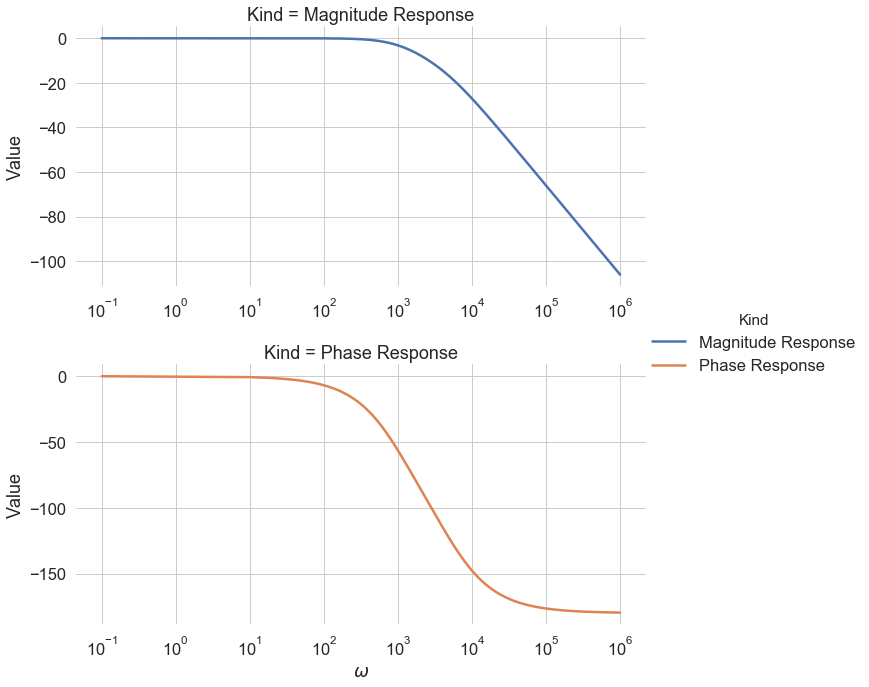

In [8]:
num = [5 * 10 ** 6]
den = convolve_all([[1, 6 * 10 ** 3, 5 * 10 ** 6]])

df, m, w = magnitude_phase_response(num, den, [0.1, 10 ** 6], 10)
g = create_plots(df)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)


### Part ii

For starters, lets' take a look at the step response of this system to the system with no compensation network.

/usr/local/lib/python3.7/site-packages/scipy/signal/filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


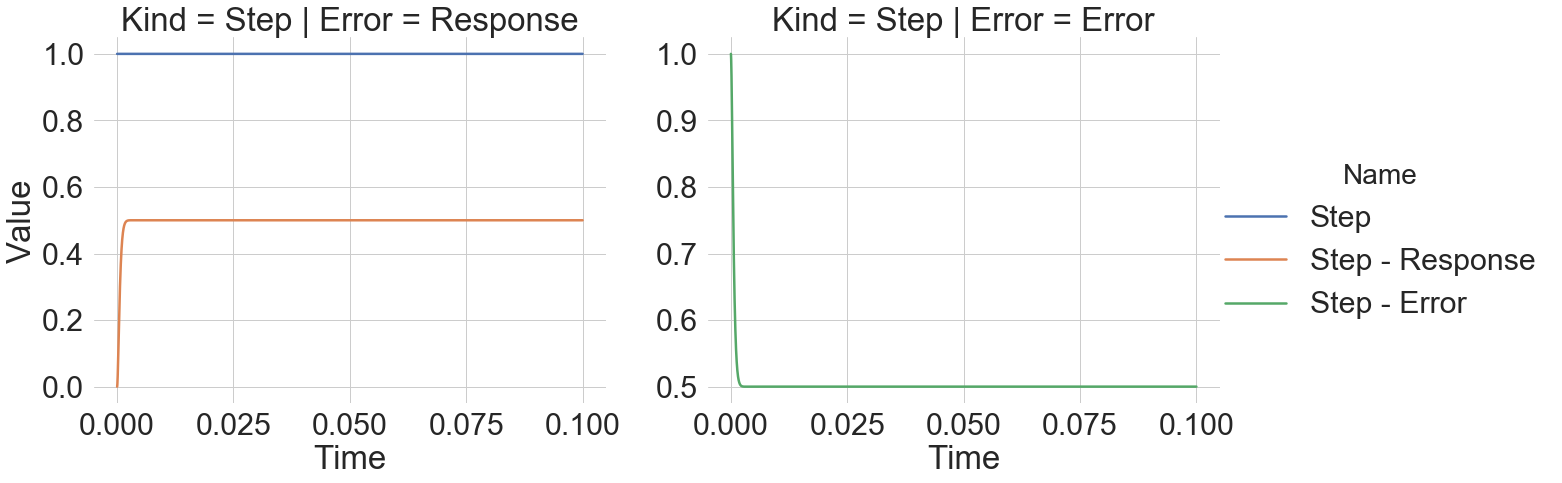

In [9]:
t = np.arange(0, 0.1, 0.00001)
df = response_to_inputs(num, den, [step], ["Step"], t)
create_plots(df, True);

First, I'll test a compensation network with just an increased gain. The steady state error of the unity response is determined by:

$$e_{ss}^{step}=\frac{1}{1+lim_{s\to 0}H_0(s)}$$

$$e_{ss}^{step}=\frac{1}{1+lim_{s\to 0}(\frac{5\cdot 10^6}{s^2+6\cdot 10^3s+5\cdot 10^6})}$$

$$e_{ss}^{step}=\frac{1}{1+1}=0.5$$

In order to get this below one percent (0.01), I'll choose a gain according to the following:

$$e_{ss}^{step}=\frac{1}{1+lim_{s\to 0}(K\cdot \frac{5\cdot 10^6}{s^2+6\cdot 10^3s+5\cdot 10^6})}=0.01$$

$$e_{ss}^{step}=\frac{1}{1+K}=0.01$$

$$1=0.01+0.01\cdot K \rightarrow 0.99=0.01\cdot K$$

$$K=99$$

Therefore a gain of $100$ would produce the desired reduction in error (+ some wiggle room). 

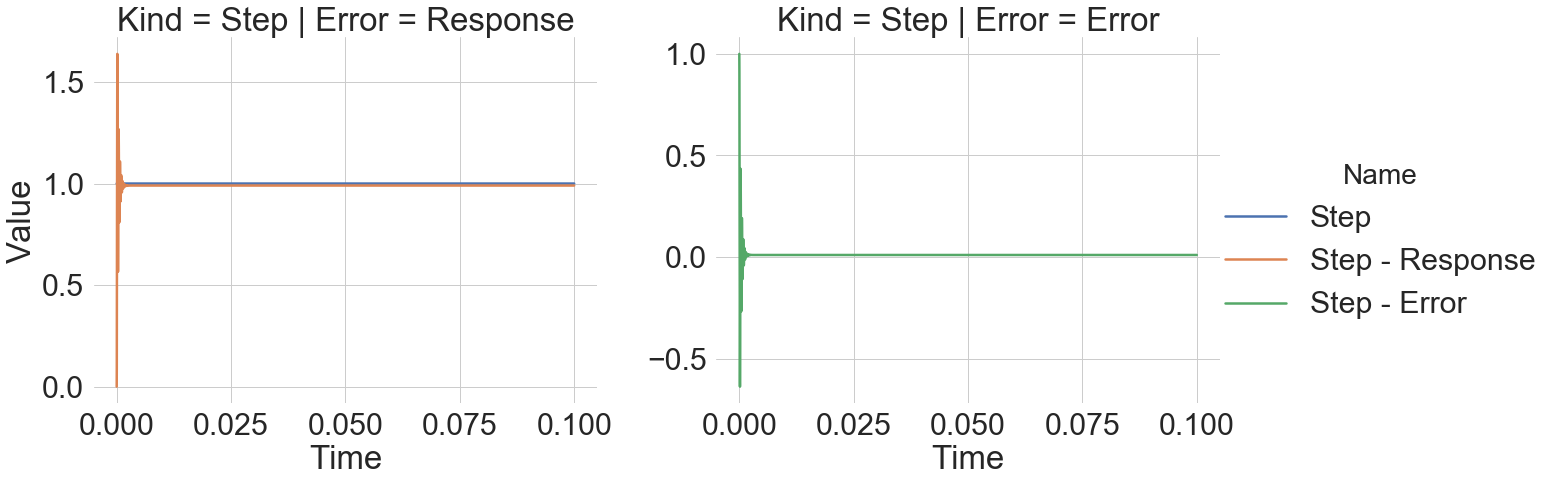

In [10]:
comp_network_num = [100]
comp_network_den = [1]
 
t = np.arange(0, 0.1, 0.00001)
df = response_to_inputs(num, den, [step], ["Step"], t, comp_network_num, comp_network_den)
create_plots(df, True);

This seems to satisfy the problem requirements for the steady-state error, but let's look at the values at 5 milliseconds, just to be sure.

In [11]:
display(df[(df["Time"] == 5 / 1000) & (df["Error"] == "Error")])

,Time,Value,Kind,Name,Error
20500,0.005,0.009901,Step,Step - Error,Error


As we can see, at 5 milliseconds, the step error for this new transfer function is below 1%. Now, the overshoot needs to be dealt with.

Let's take a look at the phase margin for this new system, to identify how much phase offset we need to add.

Crossover at 20803.534 (rad/s) has a phase-margin of 16.266 degrees


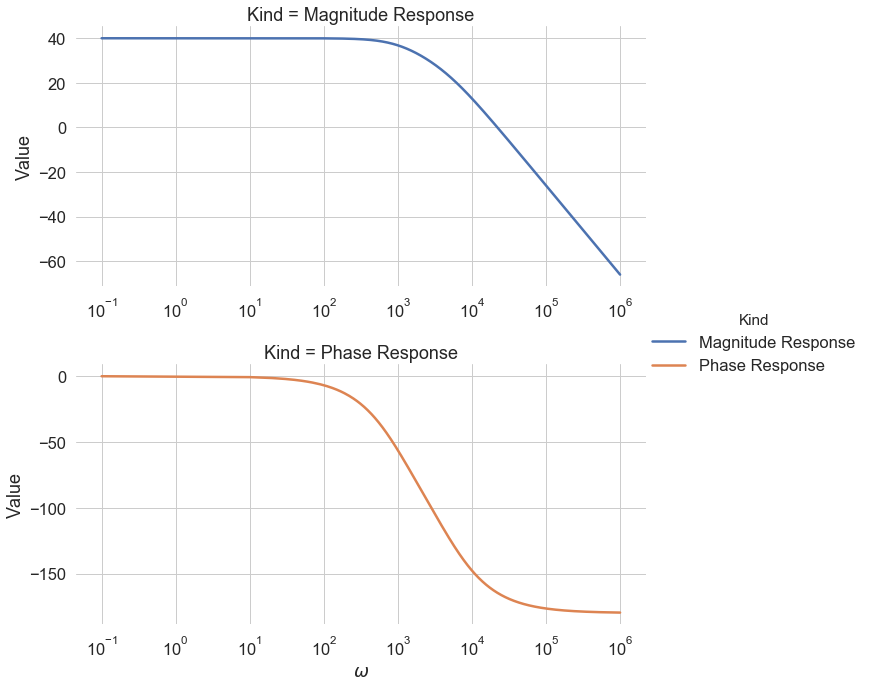

In [13]:
df, phase_margin, crossover_w = magnitude_phase_response(num, den, [0.1, 10 ** 6], 10,
                                                         comp_network_num, comp_network_den)
print ("Crossover at {:.3f} (rad/s) has a phase-margin of {:.3f} degrees".format(crossover_w, phase_margin))

This phase margin, of only $16.266$ degrees, is clearly the reason we have such an overshoot when it comes to the step response. To deal with this, let's add a phase lead compensation. I chose a desired phase of $100^o$, since we want __no overshoot whatsoever__.

In [14]:
z, p = compute_phase_lead(df, 100 - phase_margin)
print ("Zero: {:.2f} (rad/s)\nPole: {:.2f} (rad/s)".format(z, p))

Zero: 5228.13 (rad/s)
Pole: 1744826.86 (rad/s)


After computing the calculated zero and pole of the compensation network, the final transfer function is:

$$G_c(s)=100\cdot \frac{1744826.86}{5228.13}\cdot \frac{s+5228.13}{s+1744826.86}$$

Now, I'll take a look at the final step response of this system - with the compensation network added.

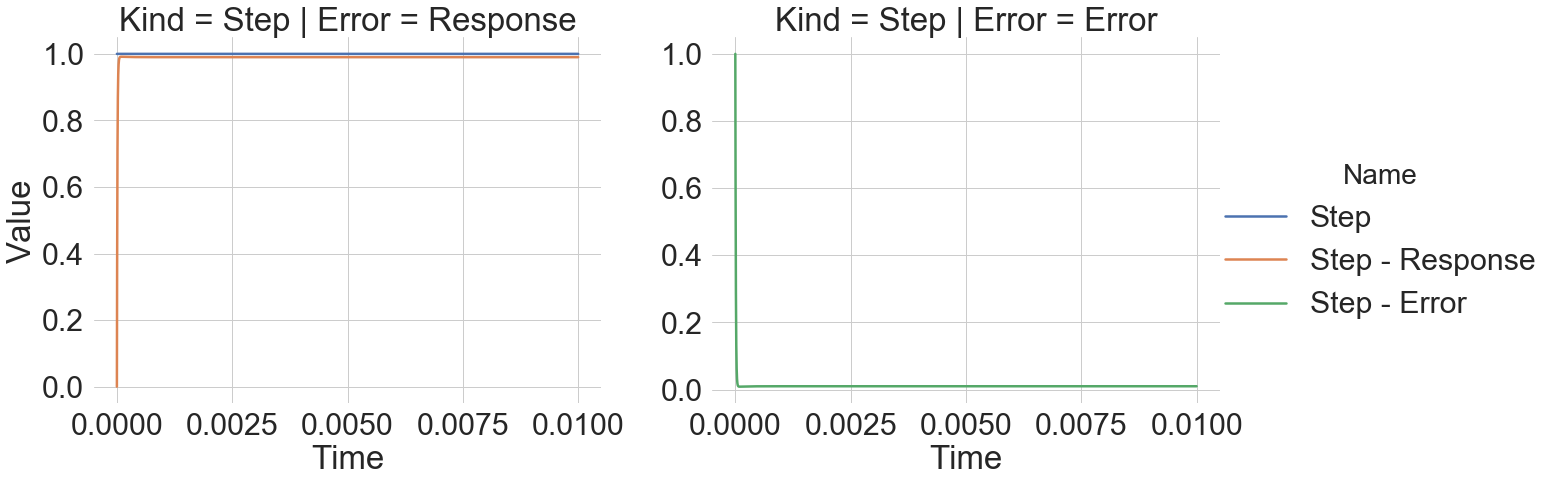

In [15]:
comp_network_num = np.multiply(100 * p / z, [1, z])
comp_network_den = [1, p]
 
t = np.arange(0, 0.01, 0.000001)
df = response_to_inputs(num, den, [step], ["Step"], t, comp_network_num, comp_network_den)
create_plots(df, True);

This appears to do the job. There is no overshoot, and the response to the unit step function definitely reaches equilibrium by 5 milliseconds. However, just to verify, here is the error at this time:

In [16]:
df[(df["Error"] == "Error") & (df["Time"] == 5 / 1000)]

,Time,Value,Kind,Name,Error
25000,0.005,0.009901,Step,Step - Error,Error



## Problem B

### Part i

There is clearly a low pass filter with two poles. The reason we know this is because the phase settles out to -180 degrees, and does not appear to increase or have any zeros of the plotted range.

My first estimation is that the dominant pole exists at $10^0$, or $1$. I am making this estimation because the magnitude response begins to decrease at this point, and the phase reaches $-45^o$ at this frequency. The next pole clearly exists at $10^1$, or $10$. Once again, we can see the magnitude transition from a $-20 \frac{dB}{dec}$ slope to $-40 \frac{dB}{dec}$ (suggesting a pole) - __and__ and frequency is at $-135^o$ at this point.

That results in the following approximated transfer function:

$$H(s)=K\cdot \frac{1}{(s+1)(s+10)}$$

However, we see that at near zero frequencies ($w\approx 0$), the magnitude of the response is 20dB. In order to achieve this gain, K needs to be approximately 100 - we know this because each gain of 10 corresponds to 20dB, and the starting gain of this equation is -20dB.

Thus, the following is the final transfer function:

$$H(s)=\frac{100}{(s+1)(s+10)}$$

Crossover at 7.173 (rad/s) has a phase-margin of 62.286 degrees


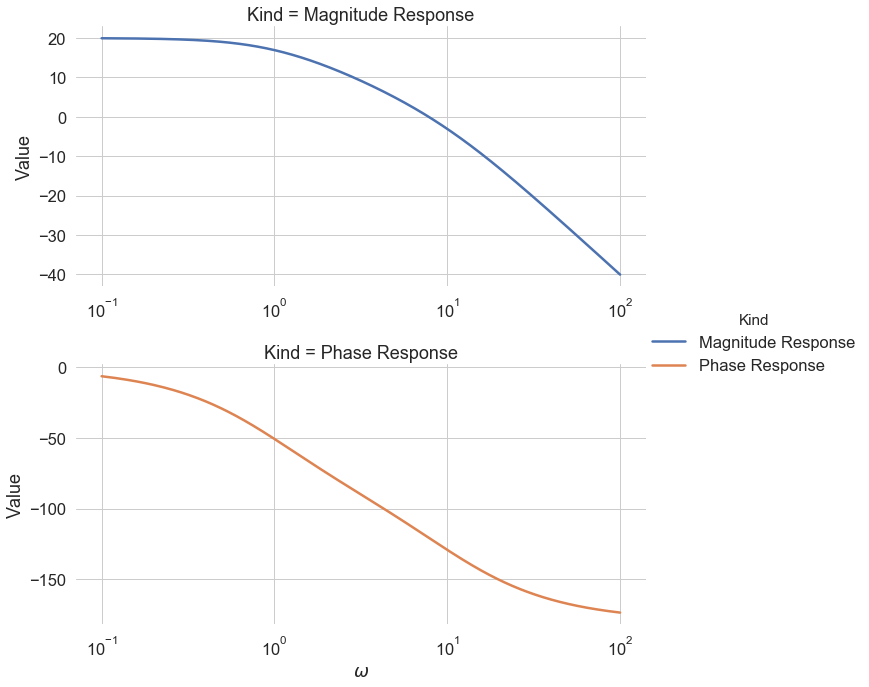

In [17]:
num = [100]
den = convolve_all([[1, 1], [1, 10]])

df, m, w = magnitude_phase_response(num, den, [10 ** -1, 10 ** 2], .01)
print ("Crossover at {:.3f} (rad/s) has a phase-margin of {:.3f} degrees".format(w, m))
g = create_plots(df)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

Which seems to match the given Bode plot. 

### Part ii

Let's start by looking at the position and velocity response.

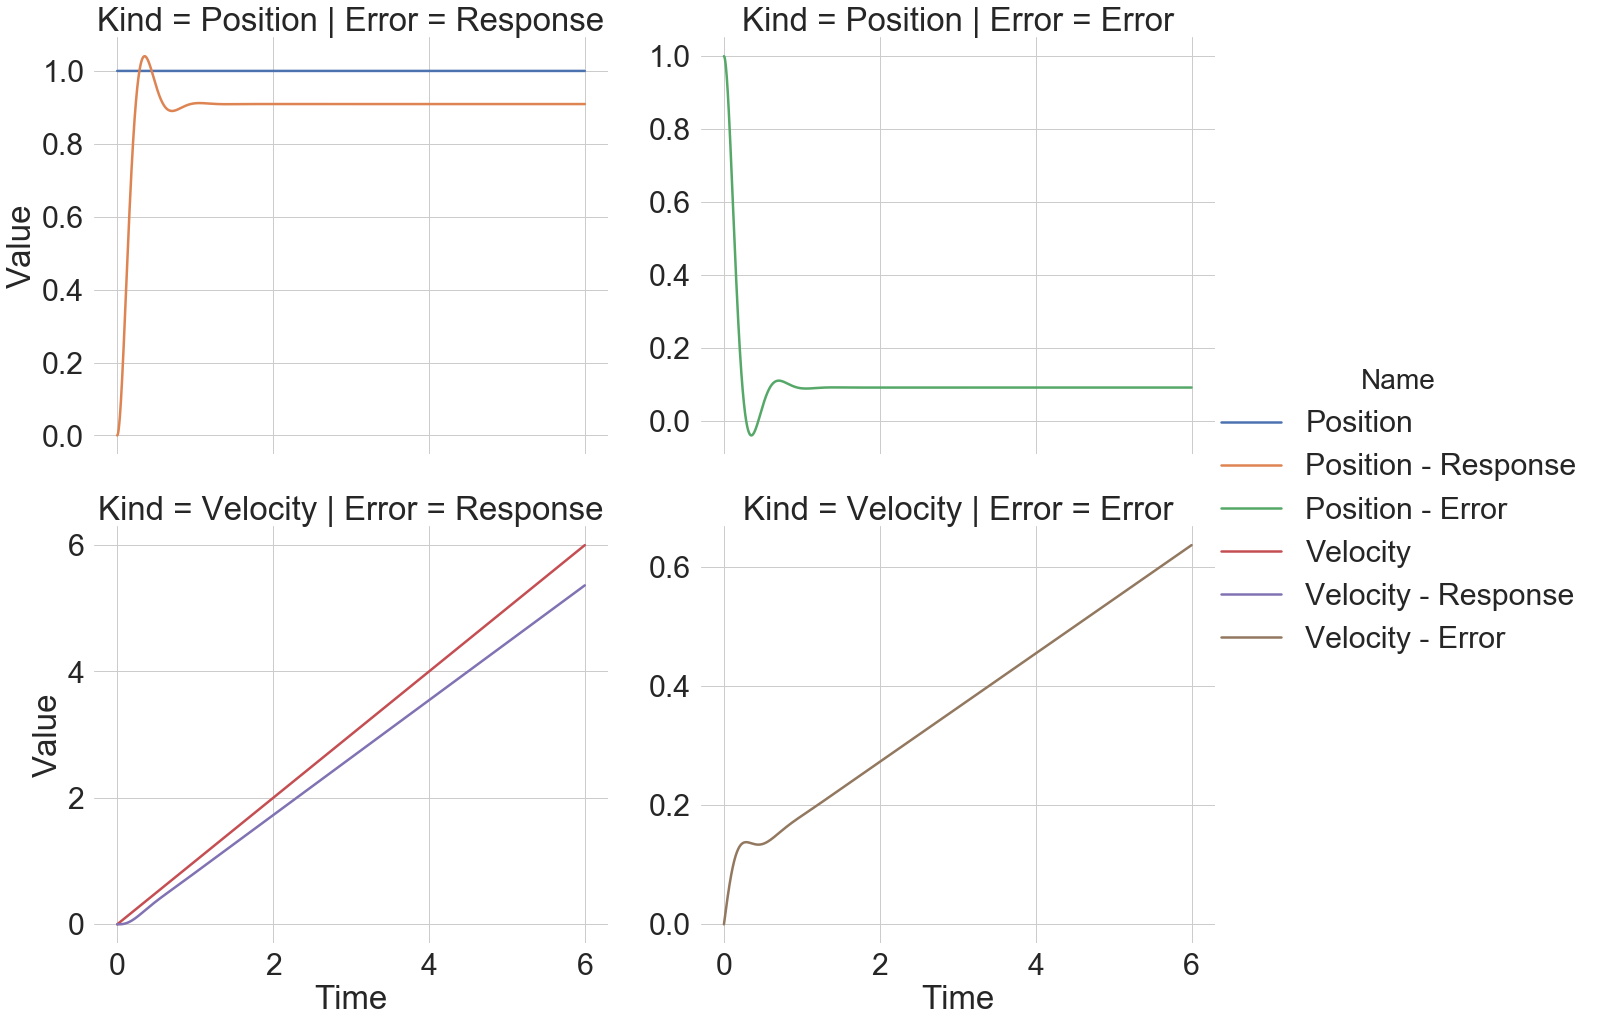

In [18]:
t = np.arange(0, 6, 0.001)
df2 = response_to_inputs(num, den, [step, ramp], ["Position", "Velocity"], t)
create_plots(df2, True);

I can see that the position error seems to stabilize to about 10%, but the velocity error is unbounded. In order to address this, I need to institute a compensation network that reduces the steady-state velocity constant to a number less than 0.1.

To accomplish this, I will add a phase-lead offset, with the addition of another pole at $\omega =0$, in order to change the velocity error to a bounded value. The general form of this will be:

$$G_c(s)=\frac{\omega _p}{\omega _z}\cdot \frac{s + \omega _z}{s\cdot(s+\omega _p)}$$

In [19]:
z, p = compute_phase_lead(df, 100-m)
print ("The new frequency of the zero is {:.2f} (rad/s)\
       \nThe new frequency of the pole is {:.2f} (rad/s)".format(z, p))

The new frequency of the zero is 6.19 (rad/s)       
The new frequency of the pole is 25.71 (rad/s)


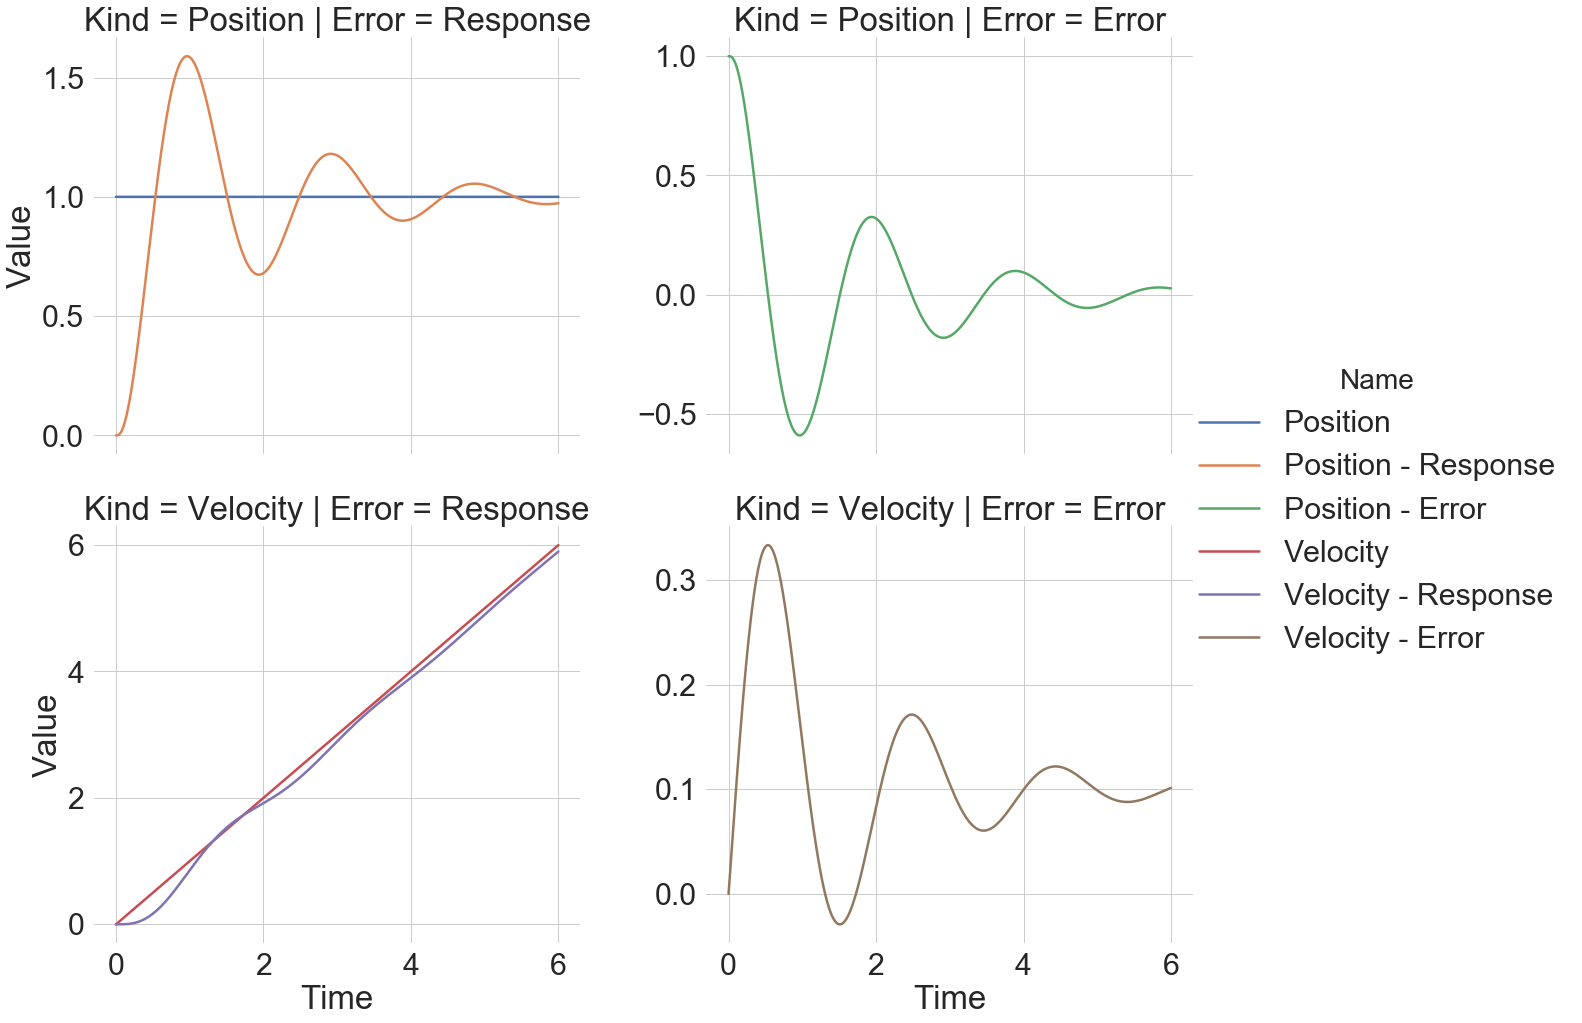

In [20]:
comp_num = np.multiply(p / z, [1, z]) # Was 7.5
comp_den = convolve_all([[1, 0], [1, p]])

t = np.arange(0, 6, 0.001)
df = response_to_inputs(num, den, [step, ramp], ["Position", "Velocity"], t, comp_num, comp_den)
create_plots(df, True);

This seems to have done the trick. Just to verify, let's look at the error of the response function at $t=5$ seconds.

In [21]:
df[(df["Time"] == 5) & (df["Error"] == "Error")]

,Time,Value,Kind,Name,Error
17000,5.0,-0.050009,Position,Position - Error,Error
35000,5.0,0.098880,Velocity,Velocity - Error,Error


As requested, the error of both the position and velocty have been reduced to below 10% after 5 seconds.